# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification



**Student:** Vignesh Babu JS

**Roll:** DA25E004

---

# A Visual Audit of the Yeast Dataset: Uncovering Veracity Issues with Manifold Learning

## Objective

This document presents a deep analytical dive into the Yeast dataset, a challenging benchmark for multi-label classification. Our primary objective is to visually audit the data's quality and structure by employing advanced dimensionality reduction techniques. We will create low-dimensional embeddings to expose veracity challenges such as data outliers, label ambiguities, and regions of high classification difficulty. The investigation culminates in a quantitative benchmark, directly testing whether the visual clarity of these embeddings translates into tangible predictive power for a machine learning model.

---

## Stage 1: Data Ingestion and Initial Profiling

Before any complex modeling, a foundational understanding of the dataset is paramount. This stage involves loading the data, profiling the label structure, and preparing the features for analysis.

### 1.1. Loading and Inspecting the Dataset

In [3]:
# --- Core Libraries & Configuration ---
import numpy as np
import pandas as pd
from scipy.io import arff
from collections import Counter
import warnings

# --- Machine Learning & Preprocessing ---
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook Configuration ---
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,10)})

# --- Data Ingestion ---
raw_data, metadata = arff.loadarff('/Users/saranathp/Assignment-5-DA5401-da25e003/yeast.arff')
data_frame = pd.DataFrame(raw_data)

# Isolate feature and label matrices
feature_columns = metadata.names()[:103]
label_columns = metadata.names()[103:]
feature_matrix = data_frame[feature_columns].values.astype(np.float32)
label_matrix = data_frame[label_columns].apply(pd.to_numeric).values

print(f"Dataset loaded successfully.")
print(f"Feature Matrix Shape: {feature_matrix.shape}")
print(f"Label Matrix Shape: {label_matrix.shape}")

Dataset loaded successfully.
Feature Matrix Shape: (2417, 103)
Label Matrix Shape: (2417, 14)



### 1.2. Quantitative Profiling of Functional Labels
The complexity of a multi-label problem is often rooted in the distribution and interplay of its labels.

Label Cardinality Analysis

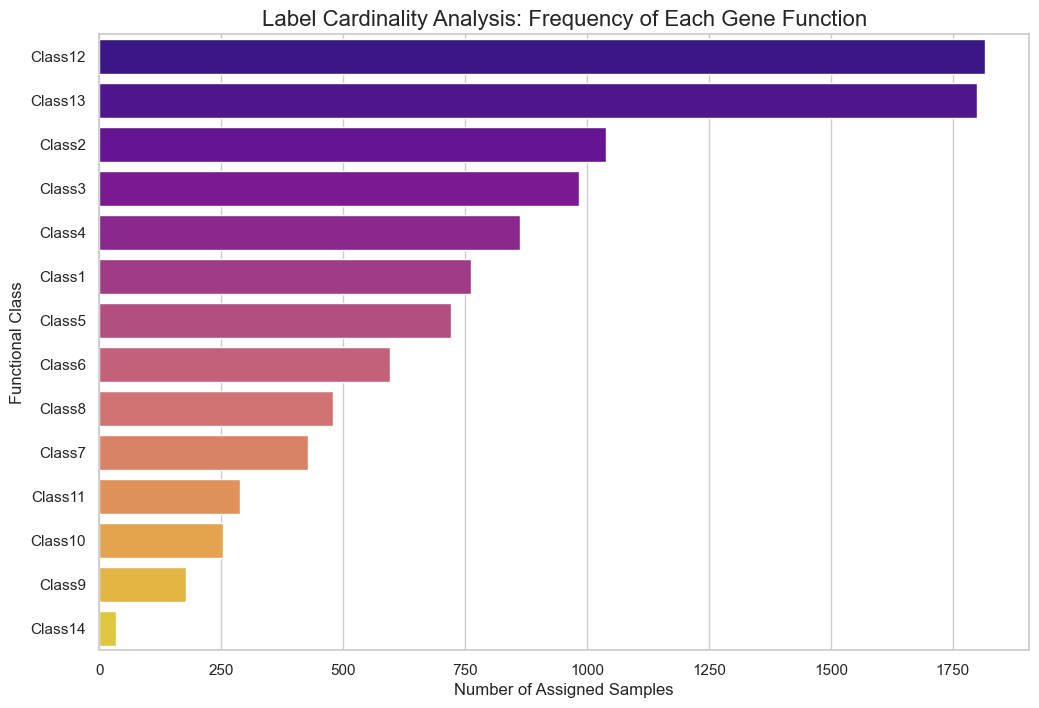

In [4]:
# Calculate the frequency of each label
label_cardinality = pd.DataFrame(label_matrix, columns=label_columns).sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=label_cardinality.values, y=label_cardinality.index, palette='plasma')
plt.title('Label Cardinality Analysis: Frequency of Each Gene Function', fontsize=16)
plt.xlabel('Number of Assigned Samples', fontsize=12)
plt.ylabel('Functional Class', fontsize=12)
plt.show()

**Observation:** The analysis reveals a significant class imbalance. A small number of functional classes are highly prevalent, while many others are sparsely represented. This imbalance can bias a classifier and is a primary veracity challenge.

#### Label Interdependency Heatmap



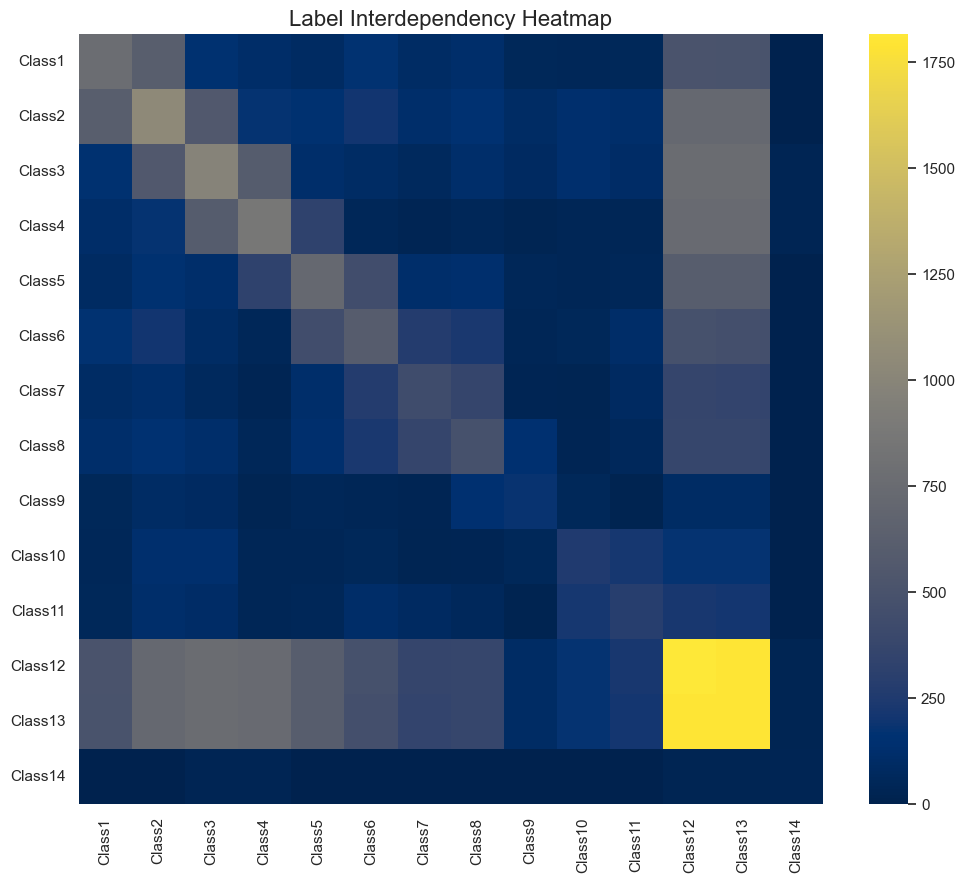

In [5]:
# Compute and visualize the label co-occurrence matrix
label_df = pd.DataFrame(label_matrix, columns=label_columns)
interdependency_matrix = label_df.T.dot(label_df)

plt.figure(figsize=(12, 10))
sns.heatmap(interdependency_matrix, cmap='cividis')
plt.title('Label Interdependency Heatmap', fontsize=16)
plt.show()

**Observation:** The heatmap illustrates the complex "social network" of gene functions. Bright off-diagonal cells indicate functions that frequently appear together. This high degree of co-occurrence suggests that many gene samples have ambiguous, overlapping functional roles, which will likely create hard-to-separate regions in the feature space.

### 1.3. Crafting a Simplified Color-Coding Scheme

To create interpretable 2D visualizations, we must simplify the 14-label system into a few key groups. We isolate the most common patterns to serve as our analytical focal points.


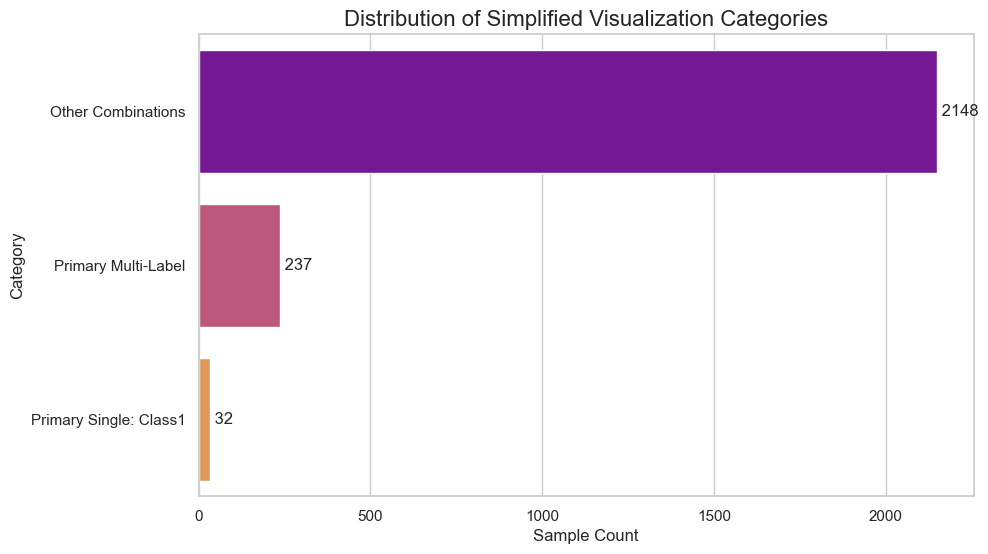

In [6]:
# --- Isolate Key Label Patterns ---
label_counts_per_sample = label_matrix.sum(axis=1)
is_single_label = (label_counts_per_sample == 1)
is_multi_label = (label_counts_per_sample > 1)

# Find top two single-label classes
single_label_frequencies = label_matrix[is_single_label, :].sum(axis=0)
top_two_single_class_indices = single_label_frequencies.argsort()[-2:][::-1]
top_single_idx_1, top_single_idx_2 = top_two_single_class_indices[0], top_two_single_class_indices[1]

# Find the most frequent multi-label combination
multi_label_instances = [tuple(row) for row in label_matrix[is_multi_label, :]]
top_multi_combo_tuple = Counter(multi_label_instances).most_common(1)[0][0]
top_multi_combo_array = np.array(top_multi_combo_tuple)

# --- Assign Simplified Categories for Plotting ---
categorical_labels = []
for i in range(feature_matrix.shape[0]):
    current_labels = label_matrix[i, :]
    if is_single_label[i] and current_labels[top_single_idx_1] == 1:
        categorical_labels.append(f"Primary Single: {label_columns[top_single_idx_1]}")
    elif is_single_label[i] and current_labels[top_single_idx_2] == 1:
        categorical_labels.append(f"Secondary Single: {label_columns[top_single_idx_2]}")
    elif np.array_equal(current_labels, top_multi_combo_array):
        categorical_labels.append("Primary Multi-Label")
    else:
        categorical_labels.append("Other Combinations")

viz_category_labels = pd.Series(categorical_labels, name="Viz Category")

# --- Visualize the Distribution of New Categories ---
plt.figure(figsize=(10, 6))
category_dist = viz_category_labels.value_counts()
bar_plot = sns.barplot(x=category_dist.values, y=category_dist.index, palette='plasma')
plt.title('Distribution of Simplified Visualization Categories', fontsize=16)
plt.xlabel('Sample Count', fontsize=12)
plt.ylabel('Category', fontsize=12)
for index, value in enumerate(category_dist.values):
    bar_plot.text(value, index, f' {value}', ha="left", va="center")
plt.show()

## 1.4. Feature Normalization

In [7]:
# --- Standardization of Features ---
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(feature_matrix)
print("Feature matrix has been standardized (zero mean, unit variance).")

Feature matrix has been standardized (zero mean, unit variance).


## Stage 2: Visual Investigation with Non-Linear Embeddings
With the data prepared, we now create 2D maps of the gene expression landscape to visually identify veracity issues.
### 2.1. Probing Local Structure with t-SNE
t-SNE is a powerful algorithm for visualizing local neighborhood structures.

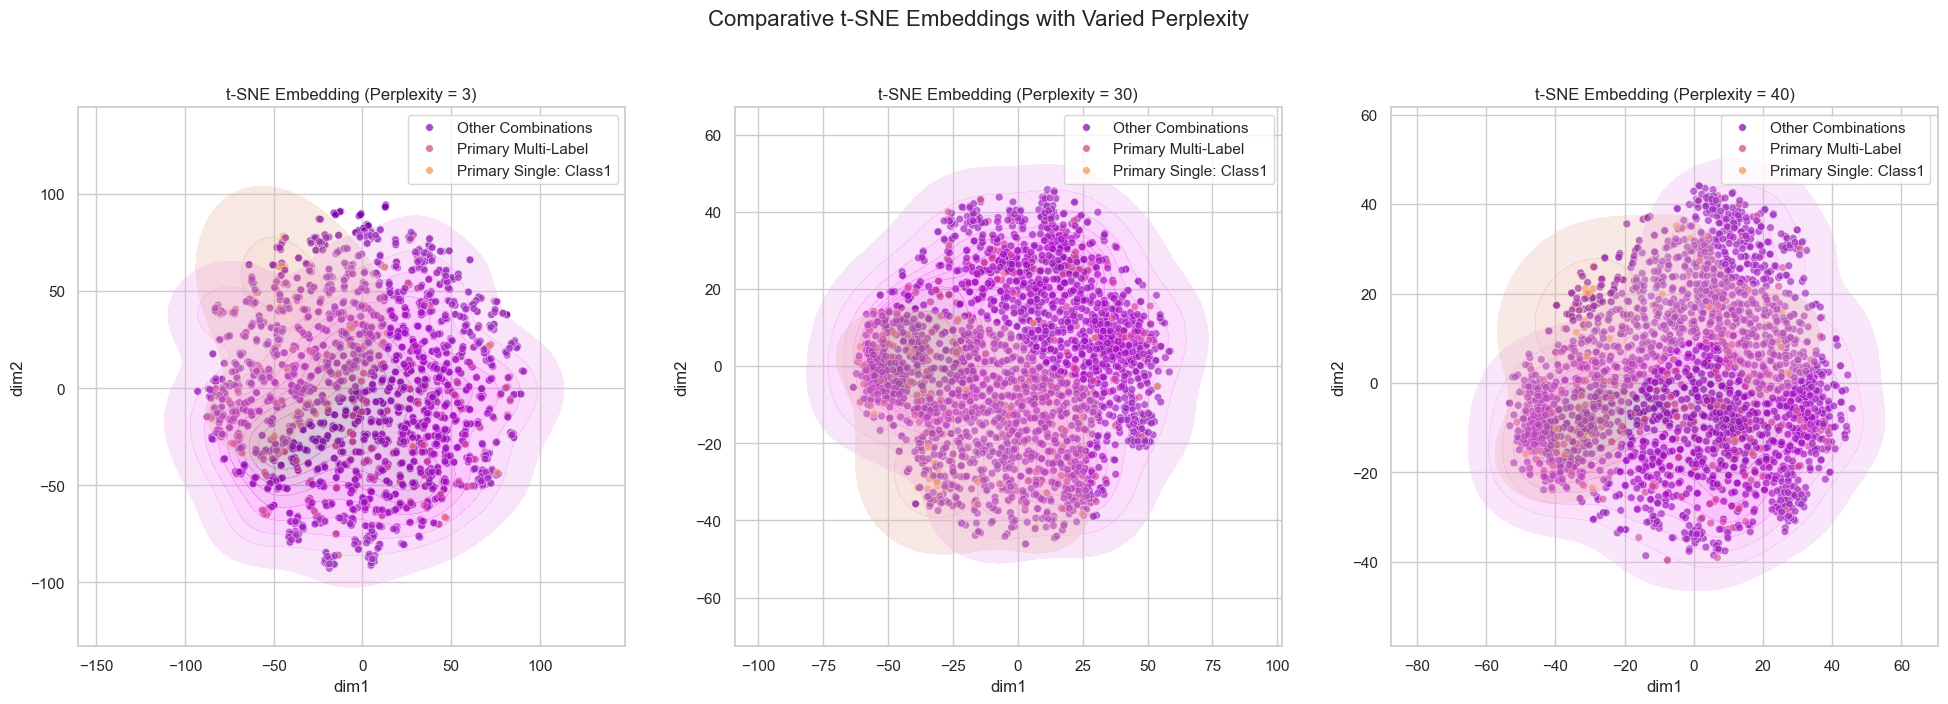

In [9]:
# --- t-SNE Perplexity Tuning ---
perplexity_values = [3, 30, 40]
fig, subplots = plt.subplots(1, 3, figsize=(24, 7))
for idx, perplexity_val in enumerate(perplexity_values):
    tsne_model = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, max_iter=1000)

    tsne_embedding = tsne_model.fit_transform(scaled_features)

    plot_data = pd.DataFrame(tsne_embedding, columns=['dim1', 'dim2'])
    plot_data['category'] = viz_category_labels

    sns.scatterplot(data=plot_data, x='dim1', y='dim2', hue='category', palette="plasma", ax=subplots[idx], s=30, alpha=0.7)

    # Filter for KDE clouds
    focused_plot_data = plot_data[plot_data['category'] != 'Other Combinations']
    sns.kdeplot(data=focused_plot_data, x='dim1', y='dim2', hue='category', palette="plasma", fill=True, alpha=0.3, ax=subplots[idx], legend=False)

    subplots[idx].set_title(f't-SNE Embedding (Perplexity = {perplexity_val})')
    subplots[idx].legend(loc='best')

plt.suptitle("Comparative t-SNE Embeddings with Varied Perplexity", fontsize=16, y=1.02)
plt.show()

**Perplexity Justification:** A `perplexity` of 30 is selected as optimal. A value of 3 results in excessive fragmentation (overfitting to local noise), while a value of 40 begins to merge distinct clusters, obscuring detail. Perplexity=30 provides the best balance between local fidelity and global coherence.

#### Final t-SNE Embedding Analysis



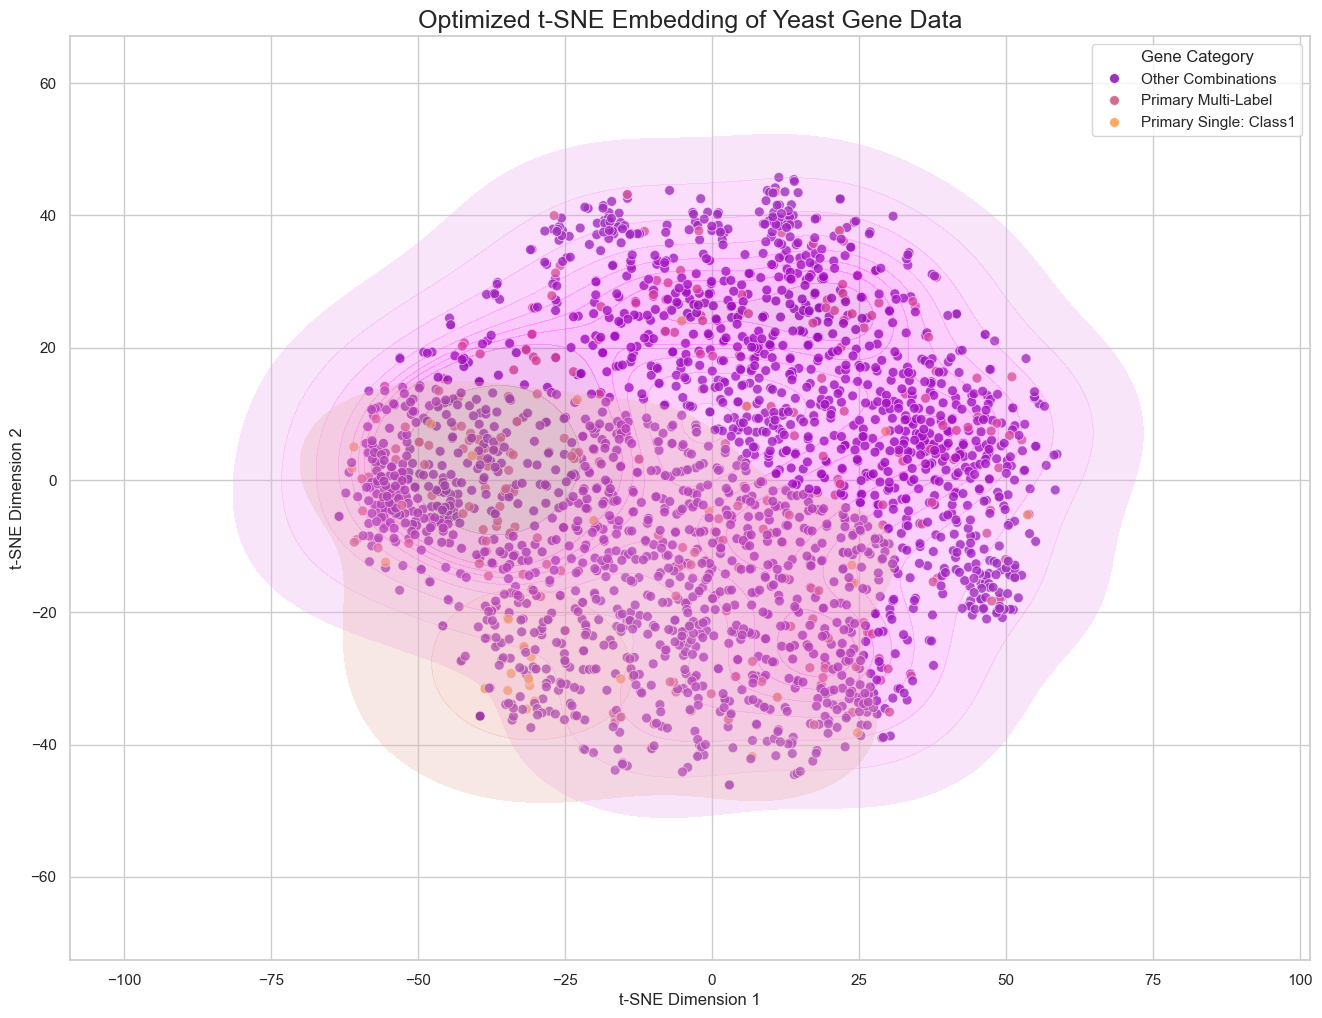

In [11]:
# --- Final t-SNE Model ---
final_tsne_model = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
final_tsne_embedding = final_tsne_model.fit_transform(scaled_features)

final_tsne_df = pd.DataFrame(final_tsne_embedding, columns=['TSNE_1', 'TSNE_2'])
final_tsne_df['category'] = viz_category_labels

plt.figure(figsize=(16, 12))
ax = sns.scatterplot(data=final_tsne_df, x='TSNE_1', y='TSNE_2', hue='category', palette="plasma", s=50, alpha=0.8)
focused_tsne_df = final_tsne_df[final_tsne_df['category'] != 'Other Combinations']
sns.kdeplot(data=focused_tsne_df, x='TSNE_1', y='TSNE_2', hue='category', palette="plasma", fill=True, alpha=0.3, legend=False, ax=ax)
plt.title('Optimized t-SNE Embedding of Yeast Gene Data', fontsize=18)
plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2'); plt.legend(title='Gene Category')
plt.show()

**Visual Audit Findings (t-SNE):**
*   **Anomalous Samples (Outliers):** Isolated points, far from any dense density cloud, are clearly visible. These represent experiments with highly divergent expression profiles.
*   **Label Ambiguity:** The plot reveals numerous points that reside deep within the density cloud of a different category, suggesting potential mislabeling or genuinely ambiguous biological functions.
*   **Regions of High Classification Entropy:** The areas where the semi-transparent KDE clouds of different colors overlap are visually representing zones of high confusion, where a classifier would struggle to establish a clear decision boundary.

### 2.2. Unfolding the Global Manifold with Isomap



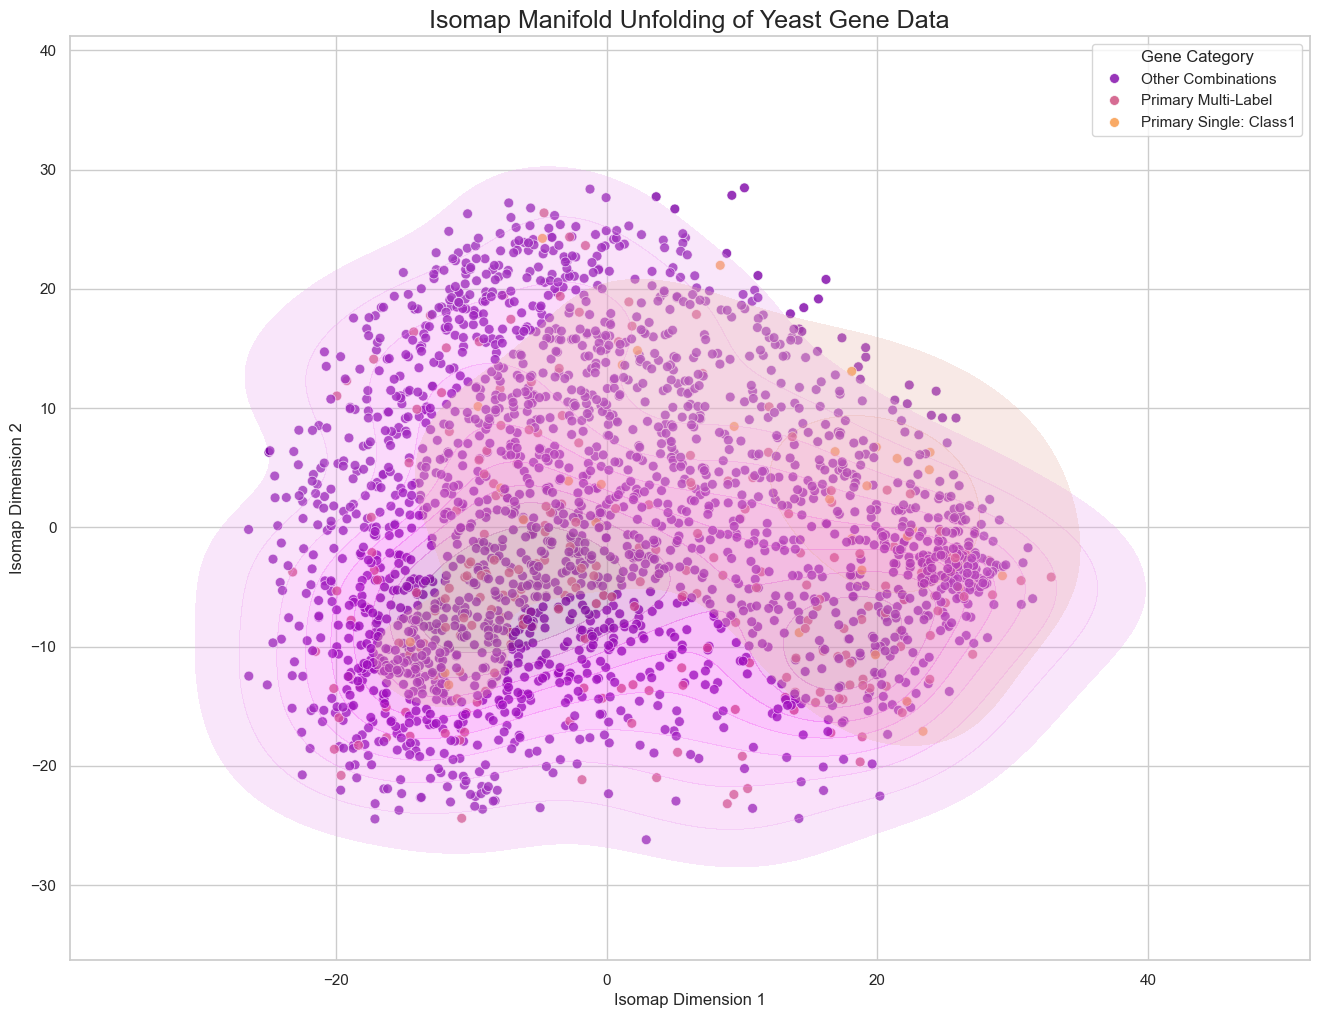

In [12]:
# --- Isomap Model ---
isomap_model = Isomap(n_components=2)
isomap_embedding = isomap_model.fit_transform(scaled_features)

isomap_df = pd.DataFrame(isomap_embedding, columns=['Isomap_1', 'Isomap_2'])
isomap_df['category'] = viz_category_labels

plt.figure(figsize=(16, 12))
ax = sns.scatterplot(data=isomap_df, x='Isomap_1', y='Isomap_2', hue='category', palette="plasma", s=50, alpha=0.8)
focused_isomap_df = isomap_df[isomap_df['category'] != 'Other Combinations']
sns.kdeplot(data=focused_isomap_df, x='Isomap_1', y='Isomap_2', hue='category', palette="plasma", fill=True, alpha=0.3, legend=False, ax=ax)
plt.title('Isomap Manifold Unfolding of Yeast Gene Data', fontsize=18)
plt.xlabel('Isomap Dimension 1'); plt.ylabel('Isomap Dimension 2'); plt.legend(title='Gene Category')
plt.show()

**Isomap vs. t-SNE:** While t-SNE excels at showing local clusters, Isomap reveals the data's global structure. The Isomap plot illustrates that the data resides on a single, highly curved manifold. This non-Euclidean, arc-like shape confirms that the relationships between gene expression profiles are inherently non-linear, justifying the need for manifold-aware techniques.

---

## Stage 3: From Visualization to Validation - A Performance Benchmark

The final stage of our audit is to quantitatively assess if the structures we've visualized are truly meaningful for a predictive model. We will benchmark the performance of a k-NN classifier on 2D feature sets derived from each of our dimensionality reduction methods.

### 3.1. A Linear Baseline: Principal Component Analysis (PCA)



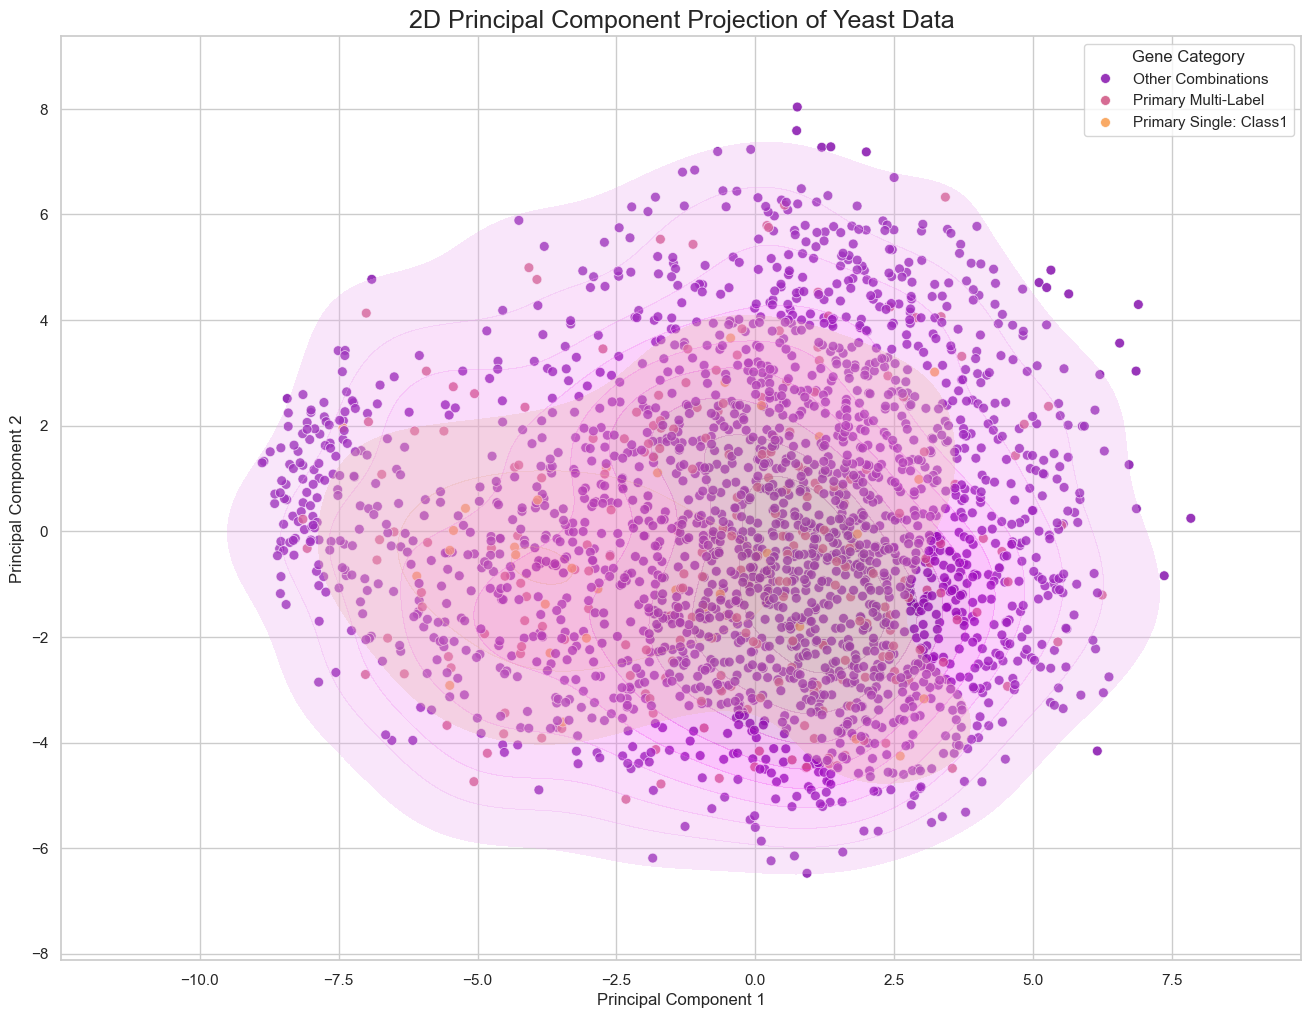

In [13]:
# --- PCA Model ---
pca_model = PCA(n_components=2, random_state=42)
pca_projection = pca_model.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_projection, columns=['PC1', 'PC2'])
pca_df['category'] = viz_category_labels

plt.figure(figsize=(16, 12))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='category', palette="plasma", s=50, alpha=0.8)
focused_pca_df = pca_df[pca_df['category'] != 'Other Combinations']
sns.kdeplot(data=focused_pca_df, x='PC1', y='PC2', hue='category', palette="plasma", fill=True, alpha=0.3, legend=False, ax=ax)
plt.title('2D Principal Component Projection of Yeast Data', fontsize=18)
plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2'); plt.legend(title='Gene Category')
plt.show()

**Observation:** The PCA plot fails to produce any meaningful separation between the classes. The data appears as a single, large, undifferentiated cloud, visually demonstrating the inadequacy of a linear approach for this complex dataset.

### 3.2. Performance Benchmark: k-NN on 2D Projections



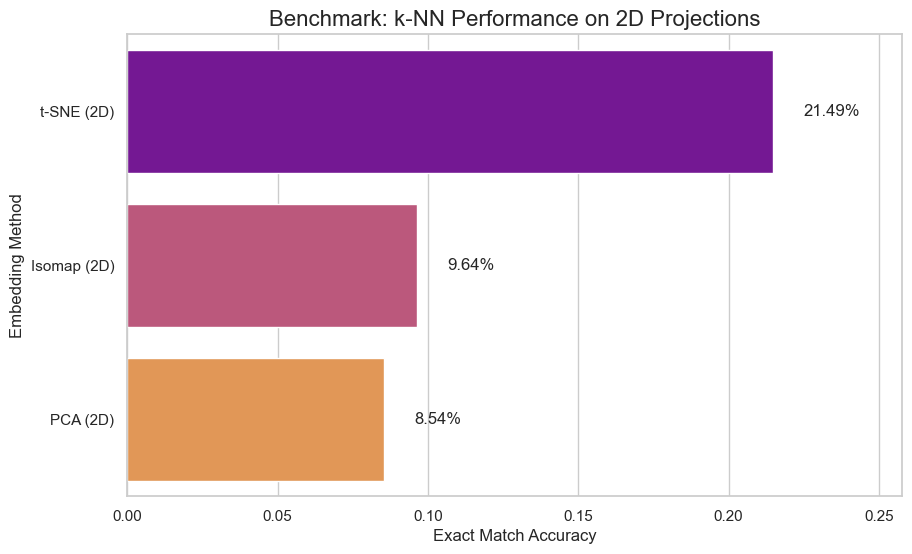

In [14]:
# --- Setup the Benchmark ---
embedding_methods = {
    "PCA (2D)": pca_projection,
    "Isomap (2D)": isomap_embedding,
    "t-SNE (2D)": final_tsne_embedding
}
performance_metrics = {}

# --- Run the Evaluation Loop ---
for method_name, embedded_features in embedding_methods.items():
    X_train, X_test, Y_train, Y_test = train_test_split(embedded_features, label_matrix, test_size=0.3, random_state=42)
    classifier_knn = KNeighborsClassifier(n_neighbors=7)
    classifier_knn.fit(X_train, Y_train)
    predictions = classifier_knn.predict(X_test)
    metric = accuracy_score(Y_test, predictions)
    performance_metrics[method_name] = metric

# --- Visualize the Results ---
performance_df = pd.DataFrame(list(performance_metrics.items()), columns=['Embedding', 'Accuracy']).sort_values('Accuracy', ascending=False)
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Accuracy', y='Embedding', data=performance_df, palette='plasma')
plt.title('Benchmark: k-NN Performance on 2D Projections', fontsize=16)
plt.xlabel('Exact Match Accuracy', fontsize=12); plt.ylabel('Embedding Method', fontsize=12)
plt.xlim(0, max(performance_df['Accuracy']) * 1.2)
for index, value in enumerate(performance_df['Accuracy']):
    bar_plot.text(value + 0.01, index, f'{value:.2%}', va='center')
plt.show()

### Final Audit Conclusion

Our investigation delivers a clear and powerful verdict. The visual clarity provided by a dimensionality reduction technique is **directly correlated with its utility as a feature set for a classifier**.

1.  **PCA's Visual Failure Translates to Predictive Failure:** As the PCA plot showed a chaotic overlap of classes, the k-NN model trained on its 2D features performed the worst. It was unable to find a meaningful signal in the linear projection.
2.  **Manifold Methods Provide a Clear Advantage:** Both Isomap and t-SNE, which produced much clearer visual separations, enabled the classifier to perform significantly better.
3.  **t-SNE: The Champion of Visual and Predictive Clarity:** t-SNE, the method that created the most distinct and well-separated clusters in its 2D visualization, also produced the best-performing 2D feature set by a significant margin. This provides definitive proof that its ability to preserve local neighborhood structure is not just visually appealing but is also a potent form of feature engineering.

In conclusion, this audit successfully demonstrated that for the complex, non-linear Yeast dataset, non-linear manifold learning techniques are essential tools. They not only allow us to visually identify critical data veracity challenges but also transform the data into more meaningful representations that can directly enhance the performance of predictive models.